In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
rng = RandomState(seed)

df = pd.read_csv('./dataset/preprocessed.csv')

X, y = df.iloc[:, :-1], df.iloc[:, -1]
print(X.shape, y.shape)

(12599, 59) (12599,)


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=seed)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (10079, 59) (10079,)
Test set:  (2520, 59) (2520,)


In [3]:
# Fill missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [4]:
def cross_validation_score(estimator):
    scores = cross_val_score(
        estimator, X_test, y_test, cv=10, n_jobs=-1,
        scoring='roc_auc'
    )
    
    return scores.mean(), scores.std()


def plot_cross_validation(title, X, Y, error, xlabel, ylabel='ROC AUC'):
    plt.title(title)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

In [5]:
# Grow a full tree to get maximum depth 
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None,
                              random_state=seed)
tree.fit(X_train, y_train)
print('Depth: ', tree.get_depth())

Depth:  32


100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


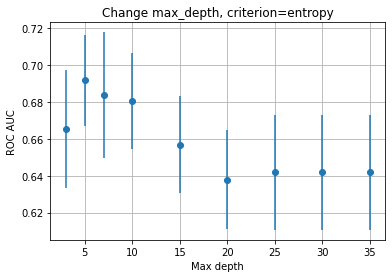

In [6]:
title = 'Change max_depth, criterion=entropy'
xlabel = 'Max depth'
max_depths = [3, 5, 7, 10, 15, 20, 25, 30, 35]
means = []
stddevs = []

for n in tqdm(max_depths):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=n, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)

plot_cross_validation(title, max_depths, means, stddevs, xlabel)
plt.savefig('./figure/DT_entropy_change_depth.png', bbox_inches='tight')
plt.show()

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


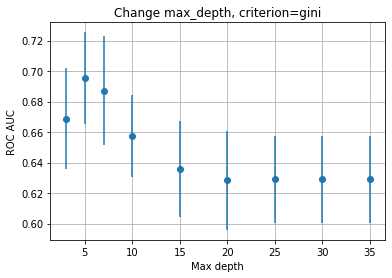

In [7]:
title = 'Change max_depth, criterion=gini'
xlabel = 'Max depth'
max_depths = [3, 5, 7, 10, 15, 20, 25, 30, 35]
means = []
stddevs = []

for n in tqdm(max_depths):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=n, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)

plot_cross_validation(title, max_depths, means, stddevs, xlabel)
plt.savefig('./figure/DT_gini_change_depth.png', bbox_inches='tight')
plt.show()

In [8]:
# Best params
from sklearn.metrics import roc_auc_score, accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                              random_state=rng)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('ROC AUC on test set: ', roc_auc_score(y_test, y_pred))

Accuracy on test set:  0.6722222222222223
ROC AUC on test set:  0.6484824360887629


In [9]:
feature_importances = tree.feature_importances_

k = 10
topk = feature_importances.argsort()[-k:][::-1]

for i in topk:
    print('%-30s: %.6f' % (X.columns[i], feature_importances[i]))

coupon_Restaurant(<20)        : 0.214508
CoffeeHouse                   : 0.200547
coupon_Carry out & Take away  : 0.143693
toCoupon                      : 0.090110
coupon_Coffee House           : 0.081872
expiration                    : 0.074068
Bar                           : 0.044872
destination_No Urgent Place   : 0.038792
time                          : 0.020458
passenger_Alone               : 0.017901


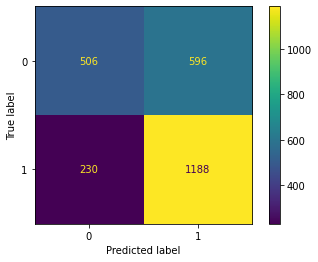

In [10]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree, X_test, y_test)
plt.savefig('./figure/DT_confmat.png')

In [11]:
from sklearn.tree import export_text

text = export_text(tree, feature_names=list(X.columns))
print(text)

|--- coupon_Carry out & Take away <= 0.50
|   |--- coupon_Restaurant(<20) <= 0.50
|   |   |--- CoffeeHouse <= 1.50
|   |   |   |--- CoffeeHouse <= 0.50
|   |   |   |   |--- coupon_Coffee House <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- coupon_Coffee House >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- CoffeeHouse >  0.50
|   |   |   |   |--- destination_No Urgent Place <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- destination_No Urgent Place >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- CoffeeHouse >  1.50
|   |   |   |--- coupon_Coffee House <= 0.50
|   |   |   |   |--- Bar <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Bar >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- coupon_Coffee House >  0.50
|   |   |   |   |--- expiration <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- expiration >  0.50
|   |   |   |   |   |--- class: 1
|   |--- coupon_Restaurant(<20) >  0.50
|   |   |--- toCou

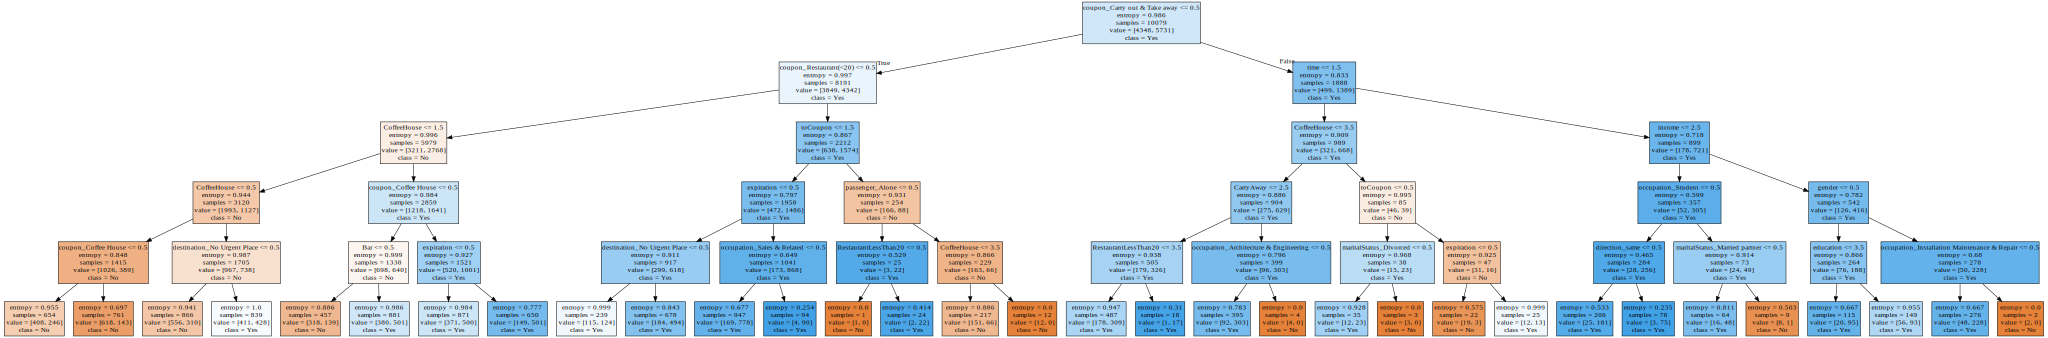

In [12]:
from sklearn.tree import plot_tree, export_graphviz
import graphviz

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=list(X.columns),
                           class_names=['No', 'Yes'],
                           filled=True)

graph = graphviz.Source(dot_data, format='png')
graph

In [13]:
graph.render("./figure/decision_tree_visualization")

'./figure/decision_tree_visualization.png'